In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint, uniform, sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import math

def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

def initilization_of_population(size,n_feat):
    population = []
    for _ in range(size):
        chromosome = {
            'depth': randint(*hyperparameter_space['depth']),
            'learning_rate': round(uniform(*hyperparameter_space['learning_rate']), 3),
            'l2_leaf_reg': round(uniform(*hyperparameter_space['l2_leaf_reg']), 2),
            'bagging_temperature': round(uniform(*hyperparameter_space['bagging_temperature']), 2),
            'iterations': randint(*hyperparameter_space['iterations']),
            'cat_features': cardinality_cols,
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'random_seed': 42,
            'verbose': 100
        }
        population.append(chromosome)
    return population

def fitness_score(population):
    scores = []
    predictions_list = []
    for chromosome in population:
        GA_CB = CatBoostRegressor(**chromosome)
        GA_CB.fit(train_data)
        GA_CB_predictions = GA_CB.predict(X_test)
        predictions_list.append(GA_CB_predictions)
        scores.append(math.sqrt(mean_squared_error(Y_test, GA_CB_predictions)))

    scores, population, predictions_list = np.array(scores), np.array(population), np.array(predictions_list)
    inds = np.argsort(scores)
    return list(scores[inds]), list(population[inds]), list(predictions_list[inds,:])

def selection(pop_after_fit,elitism):
    population_nextgen = []
    for i in range(elitism):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel, size, pop_after_fit, mutation_rate):
    pop_nextgen = pop_after_sel
    while len(pop_nextgen) < size:
        parents = sample(pop_after_fit[:5], k=2)
        parent_1 = parents[0]
        parent_2 = parents[1]
        child = {}
        for key in parent_1:
            child[key] = parent_1[key] if np.random.rand() < 0.5 else parent_2
            if np.random.rand() < mutation_rate:
                child = mutation(child)
        pop_nextgen.append(child)
    return pop_nextgen

def mutation(child):
    key = np.random.choice(['depth', 'learning_rate', 'l2_leaf_reg', 'bagging_temperature', 'iterations'])
    if key in ['learning_rate', 'l2_leaf_reg', 'bagging_temperature']:
        digits = 3 if key == 'learning_rate' else 2
        child[key] = round(uniform(*hyperparameter_space[key]), digits)
    else:
        child[key] = randint(*hyperparameter_space[key])
    return child

def generations(size,n_feat,mutation_rate,n_gen,elitism):
    best_chromo = []
    best_score = []
    best_predictions = []
    population_nextgen = initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit, predictions_list = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[0])  #2
        # print('len(population):', i+1, ':', len(pop_after_fit))
        pop_after_sel = selection(pop_after_fit,elitism)
        population_nextgen = crossover(pop_after_sel, size, pop_after_fit, mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        best_predictions.append(predictions_list[0])
        # model.fit(X_train.iloc[:, pop_after_fit[0]],Y_train)         
        # predictionsjj = model.predict(X_test.iloc[:,pop_after_fit[0]])
        # print(mean_absolute_error(Y_test,predictionsjj), scores[0])
    return best_chromo,best_score, best_predictions

In [27]:
# pd.set_option("display.max_rows",1000000000)
# pd.set_option("display.max_columns",1000000000)
# np.set_printoptions(threshold=np.inf)

home_data = pd.read_csv('home-data-for-ml-course/train.csv')
cardinality_cols = [cname for cname in home_data.columns if home_data[cname].dtype == "object"]
numeric_cols = [cname for cname in home_data.columns if home_data[cname].dtype in ['int64', 'float64']]
home_data.dropna(axis=0, subset=numeric_cols, inplace=True)
home_data[cardinality_cols] = home_data[cardinality_cols].astype(str)
Y_full = home_data["SalePrice"]
X_full = home_data
X_full.drop(['SalePrice'],axis = 1,inplace = True)
X_train, X_test, Y_train, Y_test = train_test_split(X_full,Y_full, test_size=0.25, random_state=42)
print("Home dataset:\n",X_full.shape[0],"Records\n", X_full.shape[1],"Features")

# display(home_data)
# display(Y_full)

Home dataset:
 1121 Records
 80 Features


In [28]:
train_data = Pool(data=X_train, label=Y_train, cat_features=cardinality_cols)
# model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, l2_leaf_reg=3, 
#                           loss_function='RMSE', eval_metric='RMSE', early_stopping_rounds=50, 
#                           cat_features=cardinality_cols, task_type='GPU', devices='0', random_seed=42, verbose=100)
hyperparameter_space = {'depth': (3, 8),
                        'learning_rate': (0.01, 0.2),
                        'l2_leaf_reg': (2, 20),
                        'bagging_temperature': (0.0, 1.5),
                        'iterations': (100, 1500),
                        'cat_features': cardinality_cols,
                        'loss_function': 'RMSE',
                        'eval_metric': 'RMSE',
                        'random_seed': 42,
                        'verbose': 100}
CB = CatBoostRegressor(cat_features=cardinality_cols, loss_function='RMSE', eval_metric='RMSE', random_seed=42, verbose=100)
# model = CatBoostRegressor(**hyperparameter_space)
CB.fit(train_data)
CB_predictions = CB.predict(X_test)
CB_score = math.sqrt(mean_squared_error(Y_test, CB_predictions))
print("CB_score:", CB_score)

chromo_df_bc,score_bc, predictions_list = generations(size=3,n_feat=X_full.shape[1],mutation_rate=0.20,n_gen=3, elitism=2)
# chromo_df_bc,score_bc, predictions_list = generations(size=30,n_feat=X_full.shape[1],mutation_rate=0.20,n_gen=30, elitism=2)

G_best_index = score_bc.index(min(score_bc))
G_best_score, G_best_chromo, G_best_predictions = score_bc[G_best_index], chromo_df_bc[G_best_index], predictions_list[G_best_index]

print("GA_CB_score:", G_best_score)

# model.fit(X_train.iloc[:,G_best_chromo], Y_train)        
# XGB_GA_predictions = model.predict(X_test.iloc[:,G_best_chromo])
# 

Learning rate set to 0.03983
0:	learn: 78098.2973119	total: 20.8ms	remaining: 20.8s
100:	learn: 25339.2694773	total: 2.45s	remaining: 21.8s
200:	learn: 19107.6551900	total: 4.13s	remaining: 16.4s
300:	learn: 15244.4621374	total: 6.02s	remaining: 14s
400:	learn: 13389.9258839	total: 7.93s	remaining: 11.8s
500:	learn: 12048.4513305	total: 9.76s	remaining: 9.72s
600:	learn: 10738.2253862	total: 11.7s	remaining: 7.78s
700:	learn: 9732.3615210	total: 13.8s	remaining: 5.89s
800:	learn: 8763.0637035	total: 15.9s	remaining: 3.95s
900:	learn: 8010.0248076	total: 18s	remaining: 1.97s
999:	learn: 7362.1687743	total: 20s	remaining: 0us
CB_score: 28291.48498339455
0:	learn: 72947.5488080	total: 21ms	remaining: 26s
100:	learn: 12629.6125204	total: 2.81s	remaining: 31.6s
200:	learn: 8219.9603429	total: 5.63s	remaining: 29s
300:	learn: 5193.6090999	total: 8.49s	remaining: 26.4s
400:	learn: 3417.8880164	total: 11.3s	remaining: 23.5s
500:	learn: 2537.5512803	total: 14.2s	remaining: 20.9s
600:	learn: 192

AttributeError: 'dict' object has no attribute '_jited'

In [13]:
print(chromo_df_bc,score_bc)

[{'depth': 4, 'learning_rate': 0.157, 'l2_leaf_reg': 8.9, 'bagging_temperature': 0.14, 'iterations': 1134, 'cat_features': ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'], 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_seed': 42, 'verbose': 100}, {'depth': 4, 'learning_rate': 0.157, 'l2_leaf_reg': 8.9, 'bagging_temperature': 0.14, 'iterations': 1134, 'cat_features': ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Land

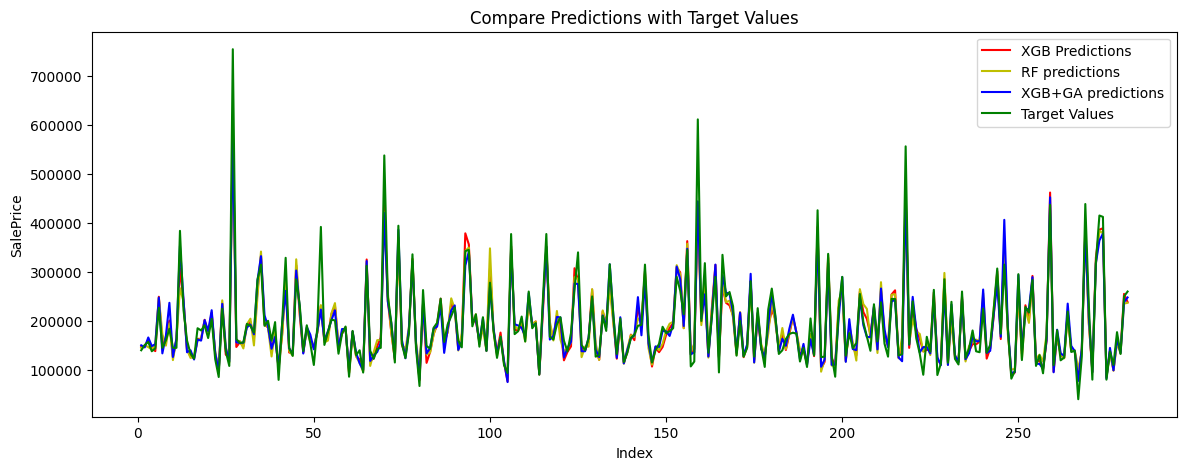

In [ ]:
# print(mean_absolute_error(Y_test, G_best_predictions))
# model.fit(X_train.iloc[:,chromo_df_bc[1]], Y_train)        
# XGB_GA_predictions = model.predict(X_test.iloc[:,chromo_df_bc[1]])
# print(mean_absolute_error(Y_test, XGB_GA_predictions))

# print(len(G_best_predictions), len(XGB_predictions), len(RF_predictions), len(Y_test))

quantity = np.arange(1, len(G_best_predictions)+1)
fig = plt.figure(figsize=(14, 5)) 
plt.plot(quantity, CB_predictions, 'r')
plt.plot(quantity, RF_predictions, 'y')
plt.plot(quantity, G_best_predictions, 'b')
plt.plot(quantity, Y_test, 'g')
plt.title('Compare Predictions with Target Values')
plt.xlabel('Index')
plt.ylabel('SalePrice')
plt.legend(['XGB Predictions', 'RF predictions', 'XGB+GA predictions', 'Target Values'])
plt.show()

In [ ]:
df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'MSLE'])
df.loc[0] = ['XGBoost', CB_score, mean_squared_error(Y_test, CB_predictions), mean_squared_log_error(Y_test, CB_predictions)]
df.loc[1] = ['Random Forests', RF_score, mean_squared_error(Y_test, RF_predictions), mean_squared_log_error(Y_test, RF_predictions)]
df.loc[2] = ['XGBoost+GA', G_best_score, mean_squared_error(Y_test, G_best_predictions), mean_squared_log_error(Y_test, G_best_predictions)]
display(df)

,Model,MAE,MSE,MSLE
0,XGBoost,16951.283474,7.478354e+08,0.015007
1,Random Forests,19280.928689,9.470893e+08,0.019534
2,XGBoost+GA,15800.763679,7.402106e+08,0.013700
